In [1]:
import numpy as np
from celerite2.jax.terms import ComplexTerm,SHOTerm,TermSum,RealTerm
from mind_the_gaps.simulator import Simulator
from mind_the_gaps.lightcurves import GappyLightcurve
import matplotlib.pyplot as plt
from mind_the_gaps import GPModelling
from mind_the_gaps.utils.stats import aicc
from scipy.stats import norm, ks_1samp
from mind_the_gaps.models.kernel_spec import (
    KernelParameterSpec,
    KernelSpec,
    KernelTermSpec,
)
import numpyro.distributions as dist
import jax.numpy as jnp
import corner
plt.rcParams['figure.figsize'] = [16, 8]
np.random.seed(10)

def flatten_terms(kernel):
    if isinstance(kernel, TermSum):
        terms = []
        for subterm in kernel.terms:
            terms.extend(flatten_terms(subterm))
        return terms
    else:
        return [kernel]

celerite2.jax only works with dtype float64. We're enabling x64 now, but you might run into issues if you've already run some jax code.
You can squash this warning by setting the environment variable 'JAX_ENABLE_X64=True' or by running:
>>> from jax import config
>>> config.update('jax_enable_x64', True)
/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Let's first generate a lightcurve with a complex PSD, a combination of a DRW, Matern-3/2 and a QPO (Lorentzian)

log variance of the QPO: 4.61, log_Q: 4.38, log omega: -1.38
Truth parameters: [  4.60517019  -6.45617257  -1.38099876   4.60517019  -1.85100239
   4.60517019  23.11044905   0.08459812 -18.42068074]
Kernel: <celerite2.jax.terms.TermSum object at 0x30f8daa90>


/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


i <celerite2.jax.terms.ComplexTerm object at 0x30f926c10>
i <celerite2.jax.terms.RealTerm object at 0x104bc67d0>
i <celerite2.jax.terms.ComplexTerm object at 0x30f87f190>


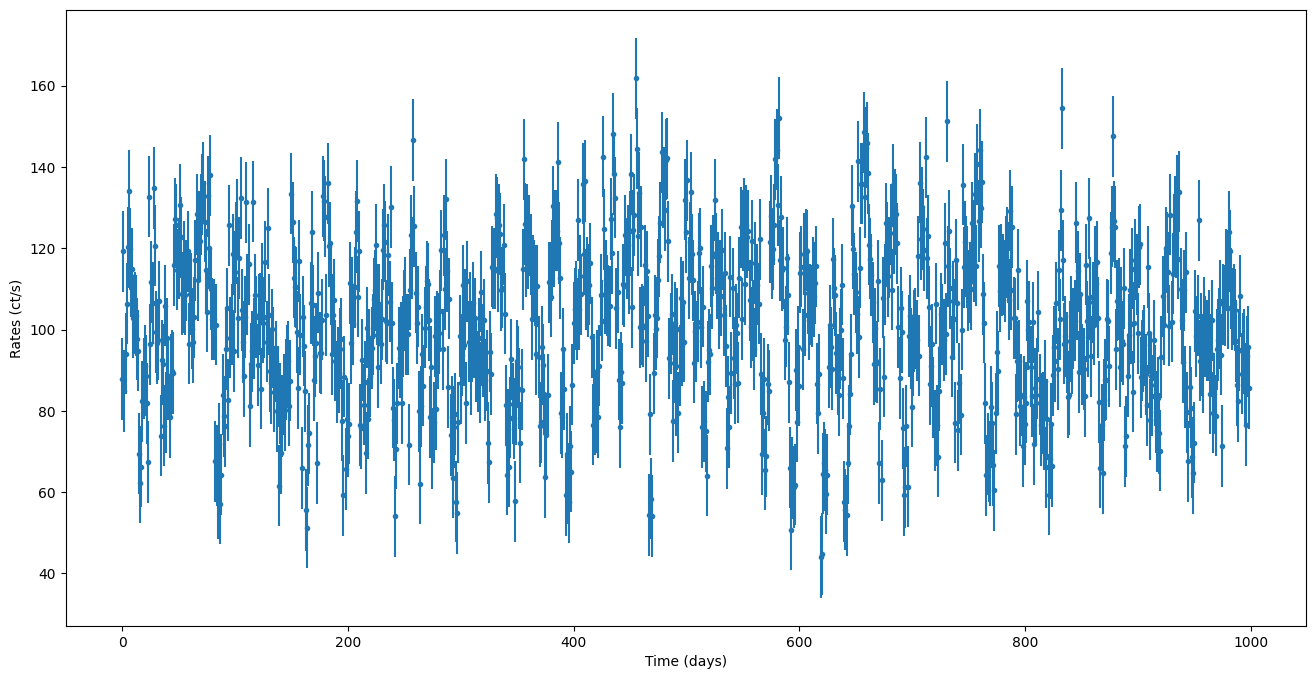

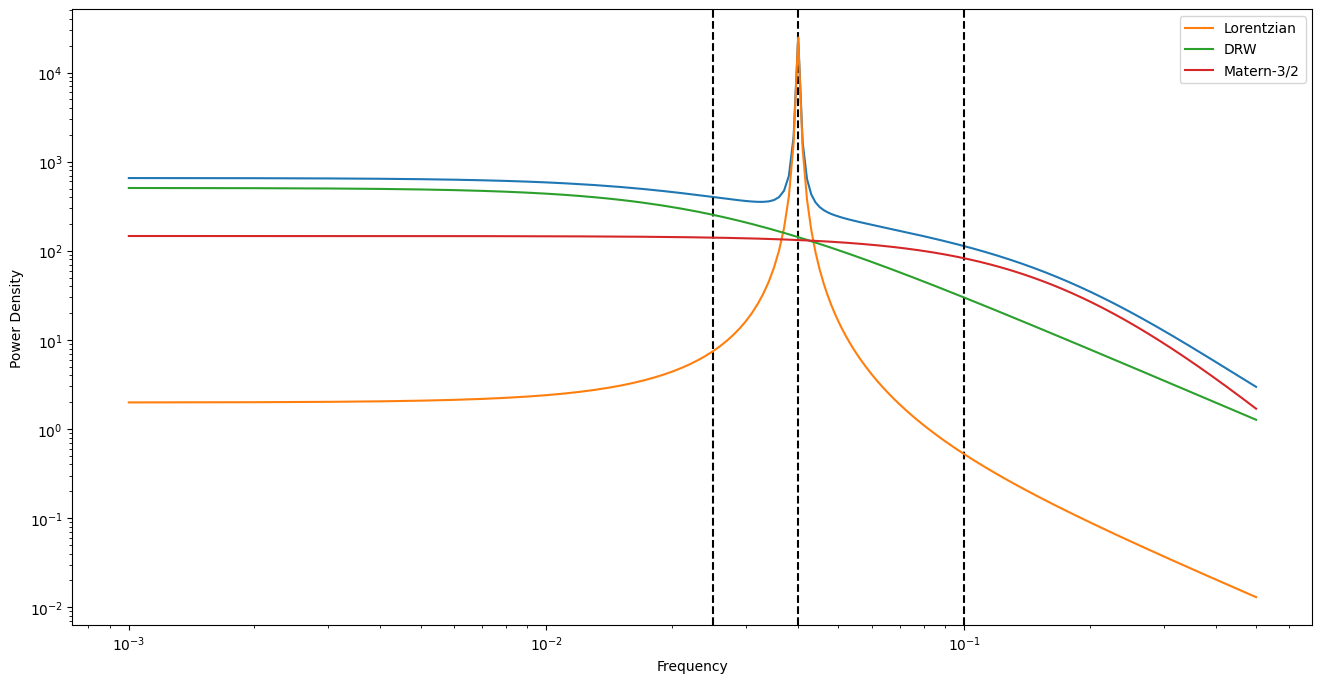

In [2]:
times = np.arange(0, 1000)
exposure = np.diff(times)[0]

# Parameters
P_qpo = 25
w = 2 * np.pi / P_qpo
mean = 100
rms = 0.1
variance_drw = (mean * rms) ** 2
P_drw = 40
w_bend = 2 * np.pi / P_drw
log_variance_qpo = np.log(variance_drw)
log_sigma_matern = np.log(np.sqrt(variance_drw))
P_matern = 10
log_rho_matern = np.log(P_matern / (2 * np.pi))
Q = 80
log_Q = np.log(Q)
log_d = np.log(w)
c = 0.5 * w / Q



eps = 1e-8

w0 = np.sqrt(3) * np.exp(-log_rho_matern)  # c parameter
S0 = np.exp(2 * log_sigma_matern) / w0  # amplitude scaling

a_mat = w0 * S0  # = sigma^2
b_mat = (w0**2) * S0 / eps  # large value ~ sigma^2 * w0 / eps
c_mat = w0  # decay rate
d_mat = eps  # tiny imaginary freq

labels = ["Lorentzian", "DRW", "Matern-3/2"]
print(f"log variance of the QPO: {log_variance_qpo:.2f}, log_Q: {log_Q:.2f}, log omega: {log_d:.2f}")

kernel_spec = KernelSpec(
    terms=[


        KernelTermSpec(
            term_class=ComplexTerm,
            parameters={
                "a": KernelParameterSpec(
                    value=log_variance_qpo, prior=dist.Uniform, bounds=(1e-5, 50.0)
                ),
                "b": KernelParameterSpec(value=0.0, zeroed=True),
                "c": KernelParameterSpec(
                    value=np.log(c), prior=dist.Uniform, bounds=(1e-5, 50.0)
                ),
                "d": KernelParameterSpec(
                    value=log_d, prior=dist.Uniform, bounds=(1e-5, 50.0)
                ),
            },
        ),
    


        # RealTerm (DRW / bending power law)

            KernelTermSpec(
                term_class=RealTerm,
                parameters={
                    "a": KernelParameterSpec(
                        value=jnp.log(variance_drw),
                        prior=dist.Uniform,
                        bounds=(-10.0, 50.0),
                    ),

                    "c": KernelParameterSpec(
                        value=jnp.log(w_bend),
                        prior=dist.Uniform,
                        bounds=(-10.0, 10.0),
                    ),

                },
            )

,                   KernelTermSpec(
            term_class=ComplexTerm,
            parameters={
                "a": KernelParameterSpec(
                    value=np.log(a_mat), bounds=(1e-12, 1e12), prior=dist.Uniform
                ),
                "b": KernelParameterSpec(
                    value=np.log(b_mat), bounds=(1e-12, 1e12), prior=dist.Uniform
                ),
                "c": KernelParameterSpec(
                    value=np.log(c_mat), bounds=(1e-12, 1e12), prior=dist.Uniform
                ),
                "d": KernelParameterSpec(
                    value=np.log(d_mat), bounds=(1e-12, 1e-4), prior=dist.Uniform
                ),
            },
            eps=eps,
        )
    ]
    
    )

kernel = kernel_spec.get_kernel()


truth = kernel_spec.get_param_array()
print(f"Truth parameters: {truth}")
print(f"Kernel: {kernel}")
psd_model = kernel.get_psd


# create simulator object with Gaussian noise
simulator = Simulator(psd_model, times, np.ones(len(times)) * exposure, mean, pdf="Gaussian", 
                      sigma_noise=10, extension_factor = 2)

# simulate noiseless count rates from the PSD, make the initial lightcurve 2 times as long as the original times
countrates = simulator.generate_lightcurve()
# add (Poisson) noise
noisy_countrates, dy = simulator.add_noise(countrates)
input_lc = GappyLightcurve(times, noisy_countrates, dy, exposures=exposure)

fig = plt.figure()
plt.errorbar(times, noisy_countrates, yerr=dy, ls="None", marker=".")
plt.xlabel("Time (days)")
plt.ylabel("Rates (ct/s)")

# plot PSD
df = 1 / input_lc.duration
nyquist = 1 / (2 * exposure)
freqs = np.arange(df, nyquist, df)
fig = plt.figure()
# remember angular freqs for the PSD models
plt.plot(freqs, psd_model(2 * np.pi * freqs))
for p in [P_qpo, P_drw, P_matern]:
    plt.axvline(1 / p, ls="--", color="black")

plt.xlabel("Frequency")
plt.ylabel("Power Density")
plt.xscale("log")
plt.yscale("log")
for i, term in enumerate(flatten_terms(kernel)):#enumerate(kernel.terms):
    print("i",term)
    plt.plot(freqs, term.get_psd(2 * np.pi * freqs), label=labels[i])
plt.legend()

lc_variance = np.var(input_lc.y)

Dummy methods to construct reasonable parameter bounds

In [3]:
def bounds_variance(variance, margin=15):
    return np.log(variance/margin), np.log(variance * margin)

def bounds_bend(duration, dt):
    nyquist = 1 / (2 * dt)
    return np.log(2 * np.pi/duration), np.log(nyquist * 2 * np.pi)

# Define models to be tested and their bounds based on the data

In [4]:
variance_bounds = bounds_variance(lc_variance)
print(variance_bounds)
bend_bounds = bounds_bend(input_lc.duration, exposure)
print(bend_bounds)
sigma_bounds = bounds_variance(np.sqrt(lc_variance))
timescale_bounds = ((np.log(exposure), np.log(input_lc.duration)))
print(timescale_bounds)
# limit Q lower bound to "periodic" components
Q_bounds = (np.log(1.5), np.log(1000))

log_var = np.log(lc_variance)

real_spec = KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=RealTerm,
                parameters={
                    "a": KernelParameterSpec(
                        value=float(log_var), bounds=variance_bounds,prior=dist.Uniform
                    ),

                    "c": KernelParameterSpec(value=float(np.log(2 * np.pi / 50)), bounds=bend_bounds,prior=dist.Uniform),

                },
            )])
log_S0=np.log(10)
log_Q = np.log(100)
log_omega0=np.log(2*np.pi/10)
S0 = np.exp(log_S0)
Q = np.exp(log_Q)
w0 = np.exp(log_omega0)

a = S0
b = 0.0
c = 0.5 * w0 / Q
d_pos = w0
d_neg = -w0
lorentzian_spec = KernelSpec(
    terms=[
        KernelTermSpec(
            term_class=ComplexTerm,
            parameters={
                "a": KernelParameterSpec(
                    value=np.log(a), prior=dist.Uniform, bounds=(-10, 50.0)
                ),
                "b": KernelParameterSpec(value=b, zeroed=True),
                "c": KernelParameterSpec(
                    value=np.log(c), prior=dist.Uniform, bounds=(-10, 50.0)
                ),
                "d": KernelParameterSpec(
                    value=np.log(d_pos), prior=dist.Uniform, bounds=(-10, 50.0)
                ),
            },
        ),
    ]
)
log_sigma = np.log(np.sqrt(lc_variance))
log_rho = np.log(10)
eps = 1e-8


w0 = np.sqrt(3) * np.exp(-log_rho_matern)  # c parameter
S0 = np.exp(2 * log_sigma_matern) / w0  # amplitude scaling

a_mat = w0 * S0  # = sigma^2
b_mat = (w0**2) * S0 / eps  # large value ~ sigma^2 * w0 / eps
c_mat = w0  # decay rate
d_mat = eps  # tiny imaginary freq
matern_spec = KernelSpec(
    terms=[KernelTermSpec(
            term_class=ComplexTerm,
            parameters={
                "a": KernelParameterSpec(
                    value=np.log(a_mat), bounds=(-10, 50), prior=dist.Uniform
                ),
                "b": KernelParameterSpec(
                    value=np.log(b_mat), bounds=(-10, 50), prior=dist.Uniform
                ),
                "c": KernelParameterSpec(
                    value=np.log(c_mat), bounds=(-10, 50), prior=dist.Uniform
                ),
                "d": KernelParameterSpec(
                    value=np.log(d_mat), bounds=(-10, 50), prior=dist.Uniform
                ),
            },
            eps=eps,
        )])

models = [real_spec, 
          matern_spec,
         lorentzian_spec + real_spec,
         lorentzian_spec + real_spec +matern_spec
          ,]

(3.283314977508742, 8.699415379713162)
(-5.068877712239209, 1.1447298858494002)
(0.0, 6.906754778648554)


# Derive AICc and p-values for the standarized residuals following a normal (0, 1) distribution

In [ ]:
cpus = 12
aiccs = []
pvalues = []
gps = []
for kernel_spec in models:
    print(kernel_spec)
    print("------------------------------------------------------------------")
    gp = GPModelling( kernel_spec=kernel_spec, lightcurve=input_lc,)
    # here we first minimize the likelihood and then run a small MCMC to ensure we find the maximum of the loglikelihood
    gp.derive_posteriors(fit=True, max_steps=4000,num_chains=4,converge_steps=500, num_warmup=1000,progress=True, max_tree_depth=7)
    best_pars = gp.max_parameters
    gp.parameters = best_pars
    std_res = gp.standardized_residuals(include_noise=True)
    pvalue = ks_1samp(std_res, norm.cdf).pvalue
    AICc = aicc(gp.max_loglikelihood, gp.k, input_lc.n)
    print(f"p-value:{pvalue:.3f} | AICC: {AICc:.2f}")
    pvalues.append(pvalue)
    aiccs.append(AICc)
    gps.append(gp)
    

/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:138: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


KernelSpec(terms=[KernelTermSpec(term_class=<class 'celerite2.jax.terms.RealTerm'>, parameters=OrderedDict([('a', KernelParameterSpec(value=Array(6.0787807, dtype=float64), fixed=False, prior=<class 'numpyro.distributions.continuous.Uniform'>, bounds=(3.283314977508742, 8.699415379713162))), ('c', KernelParameterSpec(value=Array(-2.10765947, dtype=float64), fixed=False, prior=<class 'numpyro.distributions.continuous.Uniform'>, bounds=(-5.068877712239209, 1.1447298858494002)))]))])
------------------------------------------------------------------


sample: 100%|██████████| 1001/1001 [00:00<00:00, 1460.21it/s, 3 steps of size 5.56e-01. acc. prob=0.76]
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:151: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 500/500 [00:00<00:00, 1858.78it/s, 3 steps of size 5.56e-01. acc. prob=0.93]


MCMC not converged after 500 steps.


sample: 100%|██████████| 500/500 [00:00<00:00, 1202.09it/s, 7 steps of size 5.56e-01. acc. prob=0.93]


MCMC not converged after 1000 steps.


sample: 100%|██████████| 500/500 [00:00<00:00, 1684.80it/s, 3 steps of size 5.56e-01. acc. prob=0.93]


MCMC not converged after 1500 steps.


sample: 100%|██████████| 500/500 [00:00<00:00, 1849.48it/s, 3 steps of size 5.56e-01. acc. prob=0.93]


MCMC not converged after 2000 steps.


sample: 100%|██████████| 500/500 [00:00<00:00, 2247.35it/s, 15 steps of size 5.56e-01. acc. prob=0.93]


MCMC not converged after 2500 steps.


sample: 100%|██████████| 500/500 [00:00<00:00, 1990.40it/s, 3 steps of size 5.56e-01. acc. prob=0.93] 


MCMC not converged after 3000 steps.


sample: 100%|██████████| 500/500 [00:00<00:00, 1464.73it/s, 3 steps of size 5.56e-01. acc. prob=0.93] 


MCMC not converged after 3500 steps.


sample: 100%|██████████| 500/500 [00:00<00:00, 2076.00it/s, 31 steps of size 5.56e-01. acc. prob=0.93]
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:523: UserWarning: The chains did not converge after 4000 iterations!
  warnings.warn(


MCMC not converged after 4000 steps.
p-value:0.809 | AICC: 8214.56
KernelSpec(terms=[KernelTermSpec(term_class=<class 'celerite2.jax.terms.ComplexTerm'>, parameters=OrderedDict([('a', KernelParameterSpec(value=Array(-1.74847194, dtype=float64), fixed=False, prior=<class 'numpyro.distributions.continuous.Uniform'>, bounds=(-10, 50))), ('b', KernelParameterSpec(value=Array(40.12609076, dtype=float64), fixed=False, prior=<class 'numpyro.distributions.continuous.Uniform'>, bounds=(-10, 50))), ('c', KernelParameterSpec(value=Array(42.89626229, dtype=float64), fixed=False, prior=<class 'numpyro.distributions.continuous.Uniform'>, bounds=(-10, 50))), ('d', KernelParameterSpec(value=Array(11.33596426, dtype=float64), fixed=False, prior=<class 'numpyro.distributions.continuous.Uniform'>, bounds=(-10, 50)))]))])
------------------------------------------------------------------


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:138: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 1001/1001 [00:04<00:00, 243.98it/s, 15 steps of size 2.70e-01. acc. prob=0.98]
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:151: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc 

MCMC not converged after 500 steps.


sample: 100%|██████████| 500/500 [00:00<00:00, 874.52it/s, 13 steps of size 2.70e-01. acc. prob=0.78]


MCMC not converged after 1000 steps.


sample: 100%|██████████| 500/500 [00:00<00:00, 891.46it/s, 1 steps of size 2.70e-01. acc. prob=0.78] 


MCMC not converged after 1500 steps.


sample: 100%|██████████| 500/500 [00:00<00:00, 895.35it/s, 13 steps of size 2.70e-01. acc. prob=0.78]


MCMC not converged after 2000 steps.


sample: 100%|██████████| 500/500 [00:00<00:00, 882.68it/s, 7 steps of size 2.70e-01. acc. prob=0.78] 


MCMC not converged after 2500 steps.


sample: 100%|██████████| 500/500 [00:00<00:00, 883.35it/s, 15 steps of size 2.70e-01. acc. prob=0.78]


MCMC not converged after 3000 steps.


sample: 100%|██████████| 500/500 [00:00<00:00, 959.92it/s, 4 steps of size 2.70e-01. acc. prob=0.78] 


MCMC not converged after 3500 steps.


sample: 100%|██████████| 500/500 [00:00<00:00, 937.21it/s, 7 steps of size 2.70e-01. acc. prob=0.78]  
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:523: UserWarning: The chains did not converge after 4000 iterations!
  warnings.warn(


MCMC not converged after 4000 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:138: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


p-value:0.000 | AICC: 8150.57
KernelSpec(terms=[KernelTermSpec(term_class=<class 'celerite2.jax.terms.ComplexTerm'>, parameters=OrderedDict([('a', KernelParameterSpec(value=Array(-4.08005396, dtype=float64), fixed=False, prior=<class 'numpyro.distributions.continuous.Uniform'>, bounds=(-10, 50.0))), ('b', KernelParameterSpec(value=-1e-10, fixed=True, prior=None, bounds=None)), ('c', KernelParameterSpec(value=Array(35.78266212, dtype=float64), fixed=False, prior=<class 'numpyro.distributions.continuous.Uniform'>, bounds=(-10, 50.0))), ('d', KernelParameterSpec(value=Array(36.01884718, dtype=float64), fixed=False, prior=<class 'numpyro.distributions.continuous.Uniform'>, bounds=(-10, 50.0)))])), KernelTermSpec(term_class=<class 'celerite2.jax.terms.RealTerm'>, parameters=OrderedDict([('a', KernelParameterSpec(value=Array(5.72296063, dtype=float64), fixed=False, prior=<class 'numpyro.distributions.continuous.Uniform'>, bounds=(3.283314977508742, 8.699415379713162))), ('c', KernelParameter

sample: 100%|██████████| 1001/1001 [00:17<00:00, 57.56it/s, 127 steps of size 3.43e-20. acc. prob=0.84]
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:151: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 500/500 [00:08<00:00, 55.64it/s, 127 steps of size 3.43e-20. acc. prob=0.81]


MCMC not converged after 500 steps.


sample: 100%|██████████| 500/500 [00:08<00:00, 56.68it/s, 127 steps of size 3.43e-20. acc. prob=0.81]


MCMC not converged after 1000 steps.


sample: 100%|██████████| 500/500 [00:08<00:00, 56.75it/s, 127 steps of size 3.43e-20. acc. prob=0.81]


MCMC not converged after 1500 steps.


sample: 100%|██████████| 500/500 [00:08<00:00, 56.78it/s, 127 steps of size 3.43e-20. acc. prob=0.81]


MCMC not converged after 2000 steps.


sample: 100%|██████████| 500/500 [00:08<00:00, 56.71it/s, 127 steps of size 3.43e-20. acc. prob=0.81]


MCMC not converged after 2500 steps.


sample: 100%|██████████| 500/500 [00:08<00:00, 56.62it/s, 127 steps of size 3.43e-20. acc. prob=0.81]


MCMC not converged after 3000 steps.


sample: 100%|██████████| 500/500 [00:08<00:00, 56.23it/s, 127 steps of size 3.43e-20. acc. prob=0.81]


MCMC not converged after 3500 steps.


sample: 100%|██████████| 500/500 [00:08<00:00, 56.55it/s, 127 steps of size 3.43e-20. acc. prob=0.81]
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:523: UserWarning: The chains did not converge after 4000 iterations!
  warnings.warn(


MCMC not converged after 4000 steps.
p-value:0.807 | AICC: 8208.52
KernelSpec(terms=[KernelTermSpec(term_class=<class 'celerite2.jax.terms.ComplexTerm'>, parameters=OrderedDict([('a', KernelParameterSpec(value=Array(-8.37720839, dtype=float64), fixed=False, prior=<class 'numpyro.distributions.continuous.Uniform'>, bounds=(-10, 50.0))), ('b', KernelParameterSpec(value=-1e-10, fixed=True, prior=None, bounds=None)), ('c', KernelParameterSpec(value=Array(4.5897252, dtype=float64), fixed=False, prior=<class 'numpyro.distributions.continuous.Uniform'>, bounds=(-10, 50.0))), ('d', KernelParameterSpec(value=Array(-2.60668419, dtype=float64), fixed=False, prior=<class 'numpyro.distributions.continuous.Uniform'>, bounds=(-10, 50.0)))])), KernelTermSpec(term_class=<class 'celerite2.jax.terms.RealTerm'>, parameters=OrderedDict([('a', KernelParameterSpec(value=Array(5.72332361, dtype=float64), fixed=False, prior=<class 'numpyro.distributions.continuous.Uniform'>, bounds=(3.283314977508742, 8.699415

/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:138: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 1001/1001 [01:13<00:00, 13.63it/s, 127 steps of size 6.22e-06. acc. prob=0.89]
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:151: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc 

MCMC not converged after 500 steps.


sample:  55%|█████▍    | 274/500 [00:21<00:17, 12.59it/s, 127 steps of size 6.22e-06. acc. prob=0.83]

# Finally our best-fit model is that which minimizes the AICc

In [ ]:
best_gp = gps[np.argmin(aiccs)]
print(best_gp.max_parameters)
print(f"Best model {models[np.argmin(aiccs)]} has a p-value: {pvalues[np.argmin(AICc)]:.3f}")
print(best_gp.mcmc_samples.keys())
corner_fig = corner.corner(best_gp.mcmc_samples, labels=best_gp.parameter_names, 
                           title_fmt='.1f', truths=truth,
                            quantiles=[0.16, 0.5, 0.84], show_titles=True,
                            title_kwargs={"fontsize": 18}, max_n_ticks=3, labelpad=0.08,
                            levels=(1 - np.exp(-0.5), 1 - np.exp(-0.5 * 2 ** 2))) # plots 1 and 2 sigma levels

plt.savefig("corner.png")
# 
best_gp.parameters = gp.max_parameters
print(best_gp.parameters)
pred_mean, pred_var = gp.predict(input_lc.y, return_var=True)
 # standarized residuals
plt.figure()
std_res = gp.standardized_residuals(include_noise=False)
plt.hist(norm.rvs(size=10000), edgecolor="black" , ls="--",
         facecolor="None", density=True, label="$N\sim(0, 1)$")
plt.hist(std_res, density="True", edgecolor="black", label="Data")
plt.xlabel("Standarized Residuals")
plt.ylabel("PDF")
plt.legend()
plt.savefig("std_res.png")
# ACF
plt.figure()
plt.acorr(std_res, maxlags=len(std_res) // 4 )
plt.xlim(0)
# 2 sigma
plt.axhspan(-1.96 / np.sqrt(len(std_res)), 1.96 / np.sqrt(len(std_res)), alpha=0.3, color="black")
plt.ylabel("ACF of Standarized Residuals")
plt.xlabel("Lags")
plt.savefig("acf.png")
# best-fit model
fig = plt.figure()
plt.errorbar(times, noisy_countrates, yerr=dy, ls="None", marker=".", color="black")
plt.xlabel("Time (days)")
plt.ylabel("Rates (ct/s)")
plt.plot(times, pred_mean, label="Model", color="C1")
plt.fill_between(times, pred_mean - np.sqrt(pred_var), pred_mean + np.sqrt(pred_var), 
                 zorder=10, color="C1", alpha=0.5)
plt.legend()
plt.savefig("model.png")